In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pystan
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from causalpy.bayesian_networks import LinearGaussianBN
import sympy as sym
from sympy import init_printing
init_printing(use_latex=True)
%matplotlib inline

In [2]:
def subdict(d,drop):
    result = d.copy()
    for key in drop:
        result.pop(key)
    return result

def linear_regression(data):
    X = np.vstack([data['Z'],data['X']]).T
    y = data['Y']
    lr = LinearRegression()
    lr.fit(X,y)
    return lr.coef_

def sample():
    u = np.random.normal(0,s_u,size=n)
    z = w_zu*u + np.random.normal(0,s_z,size=n)
    x = w_xz*z+np.random.normal(0,s_x,size=n)
    y = w_yx*x + w_yz*z + w_yu*u+ np.random.normal(0,s_y,size=n)
    return {"U":u,"Z":z,"X":x,"Y":y}

In [3]:
s_u = 1
s_z = 0.3
s_x = 1
s_y = 0.5

w_zu = 2
w_xz = 0.5
w_yx = 0.5
w_yz = -1.0
w_yu = 3.0


beta_x = 0.5
beta_z = -1
sigma = 0.5
n = 1000

In [4]:
data_dict = sample()
df1 = pd.DataFrame(data_dict,columns=["U","Z","X","Y"])
df1.cov()

,U,Z,X,Y
U,1.064149,2.119671,1.074853,1.612578
Z,2.119671,4.311432,2.197504,3.153899
X,1.074853,2.197504,2.080150,2.053092
Y,1.612578,3.153899,2.053092,2.944102


In [5]:
model = LinearGaussianBN()
model.add_var("X",[])
model.add_var("Y",["X"])
print model
model.cov
a = model.observe(["X"],["x"])
a.cov
a.mu[0].simplify()

X ~ N(w_X0 ; e_X)
Y ~ N(w_Y0 + w_YX*X ; e_Y)



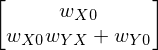

In [8]:
model.mu

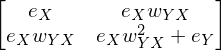

In [6]:
model.cov

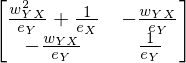

In [7]:
model.information_matrix

In [44]:
model = LinearGaussianBN()
model.add_var("U",None,[0],s_u**2)
model.add_var("Z",["U"],[0,w_zu],s_z**2)
model.add_var("X",["Z"],[0,w_xz],s_x**2)
model.add_var("Y",["U","Z","X"],[0,w_yu,w_yz,w_yx],s_y**2)

print model
data_dict = dict(zip(model.variables,model.sample(n).T))
df = pd.DataFrame(data_dict,columns=model.variables)
data = subdict(data_dict,"U")
df.cov()

U ~ N(0 ; 1)
Z ~ N(2*U ; 0.09)
X ~ N(0.5*Z ; 1)
Y ~ N(3*U + -1*Z + 0.5*X ; 0.25)



,U,Z,X,Y
U,0.956139,1.925330,0.969167,1.432384
Z,1.925330,3.965058,1.986004,2.813174
X,0.969167,1.986004,1.960876,1.889836
Y,1.432384,2.813174,1.889836,2.663881


In [45]:
linear_regression(data_dict)

array([ 0.46023691,  0.49763648])

In [52]:
stan_model_no_prior = """
data {
   int<lower=4> N; // Number of data points
   real X[N];      // the 1st predictor
   real Z[N];      // the 2nd predictor
   real Y[N];      // the outcome
}
parameters {
   real w_yx;     // x-slope
   real w_yz;     // z-slope
   real<lower=0> eps;       // dispersion
}
model {
   for (i in 1:N){
      Y[i] ~ normal(w_yx * X[i] + w_yz * Z[i], eps);
      }
}"""
data["N"] = n
fit = pystan.stan(model_code=stan_model_no_prior, data=data, iter=10000, chains=4)

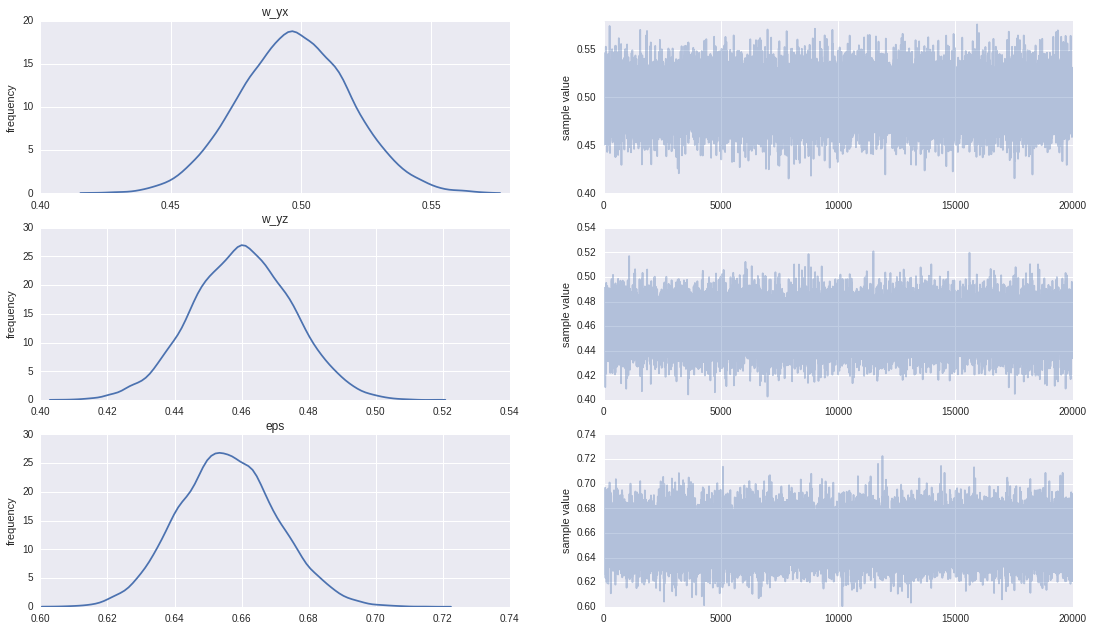

In [53]:
fit.plot()
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 10.5)
fig.savefig("prior_no_prior")

In [54]:
stan_model_with_prior = """
data {
   int<lower=4> N; // Number of data points
   real X[N];      // the 1st predictor
   real Z[N];      // the 2nd predictor
   real Y[N];      // the outcome
}
parameters {
   real w_yx;     // x-slope
   real w_yz;     // z-slope
   real<lower=0> eps;       // dispersion
}
model {
   for (i in 1:N){
      w_yx ~ normal(0,5);
      w_yz ~ normal(-1,.5);
      Y[i] ~ normal(w_yx * X[i] + w_yz * Z[i], eps);
      }
}"""
data["N"] = n
fit = pystan.stan(model_code=stan_model_with_prior, data=data, iter=10000, chains=4)

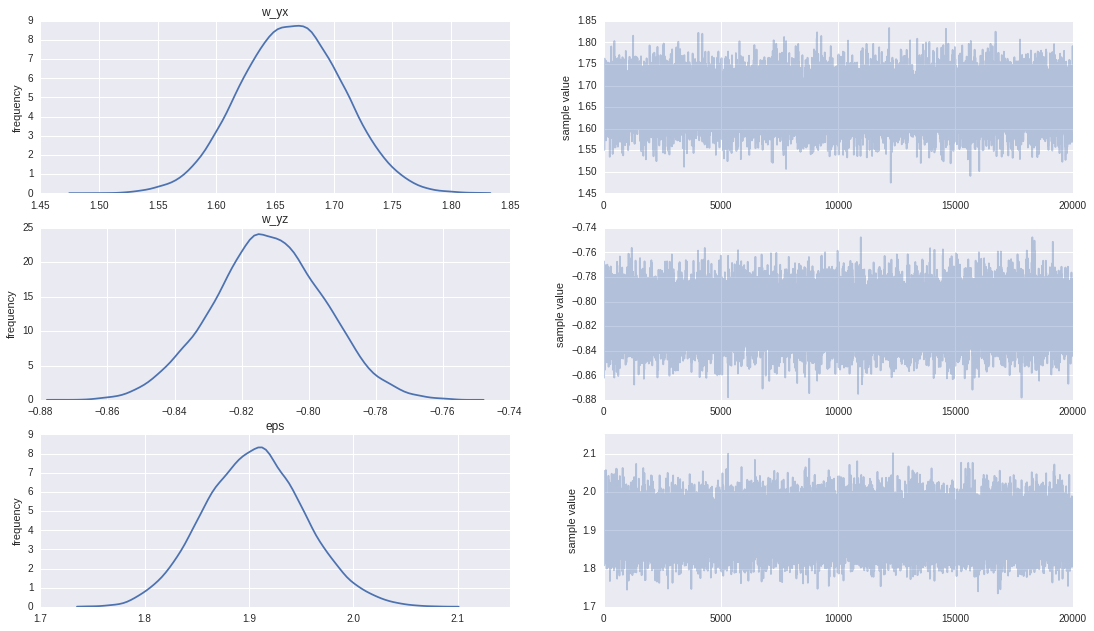

In [55]:
fit.plot()
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 10.5)
fig.savefig("prior_bad_prior.pdf")

In [56]:
stan_model_with_prior2 = """
data {
   int<lower=4> N; // Number of data points
   real X[N];      // the 1st predictor
   real Z[N];      // the 2nd predictor
   real Y[N];      // the outcome
}
parameters {
   real w_yx;     // x-slope
   real w_yz;     // z-slope
   real<lower=0> eps;       // dispersion
}
model {
   for (i in 1:N){
      w_yx ~ normal(0,5);
      w_yz ~ normal(.46,.5);
      Y[i] ~ normal(w_yx * X[i] + w_yz * Z[i], eps);
      }
}"""
data["N"] = n
fit = pystan.stan(model_code=stan_model_with_prior2, data=data, iter=10000, chains=4)

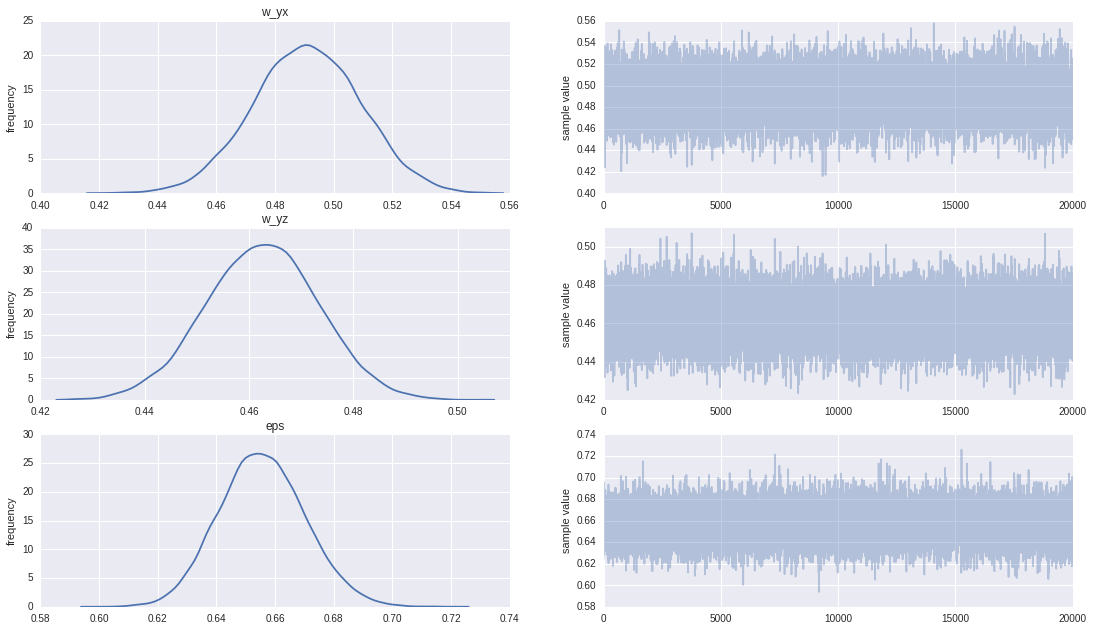

In [57]:
fit.plot()
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 10.5)
fig.savefig("prior_good_prior.pdf")